In [1]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

import numpy as np
import pandas as pd
import cudf

from xgboost import XGBClassifier

from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import OneHotEncoder
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.feature_selection import mutual_info_regression

%matplotlib inline
import plotly.figure_factory as ff
import plotly.express as px
import plotly.graph_objects as go
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('darkgrid')

import shap

In [2]:
%%time
train = cudf.read_csv('../input/tabular-playground-series-oct-2021/train.csv', index_col=0)
test = cudf.read_csv('../input/tabular-playground-series-oct-2021/test.csv', index_col=0)

sample_submission = cudf.read_csv("../input/tabular-playground-series-oct-2021/sample_submission.csv").to_pandas()

memory_usage = train.memory_usage(deep=True) / 1024 ** 2
start_mem = memory_usage.sum()

CPU times: user 4.62 s, sys: 2.16 s, total: 6.78 s
Wall time: 45.6 s


In [3]:
feature_cols = [col for col in test.columns.tolist()]

cnt_features =[]
cat_features =[]

for col in feature_cols:
    if train[col].dtype=='float64':
        cnt_features.append(col)
    else:
        cat_features.append(col)
        

train[cnt_features] = train[cnt_features].astype('float32')
train[cat_features] = train[cat_features].astype('uint8')

test[cnt_features] = test[cnt_features].astype('float32')
test[cat_features] = test[cat_features].astype('uint8')

memory_usage = train.memory_usage(deep=True) / 1024 ** 2
end_mem = memory_usage.sum()

train = train.to_pandas()
test = test.to_pandas()

In [4]:
print("Mem. usage decreased from {:.2f} MB to {:.2f} MB ({:.2f}% reduction)".format(start_mem, end_mem, 100 * (start_mem - end_mem) / start_mem))

Mem. usage decreased from 2189.64 MB to 973.70 MB (55.53% reduction)


# KMeans

In [5]:
%%time
useful_features = ["f22", "f179", "f69", "f58", "f214", "f78", "f136", "f156", "f8", "f3", "f77", "f200", "f92", "f185", "f142", "f115", "f284"]
n_clusters = 6
cd_feature = True # cluster distance instead of cluster number
cluster_cols = [f"cluster{i+1}" for i in range(n_clusters)]
kmeans = KMeans(n_clusters=n_clusters, n_init=50, max_iter=500, random_state=42)

if cd_feature:
    # train
    X_cd = kmeans.fit_transform(train[useful_features])
    X_cd = pd.DataFrame(X_cd, columns=cluster_cols, index=train.index)
    train = train.join(X_cd)
    # test
    X_cd = kmeans.transform(test[useful_features])
    X_cd = pd.DataFrame(X_cd, columns=cluster_cols, index=test.index)
    test = test.join(X_cd)
    
else:
    # train
    train["cluster"] = kmeans.fit_predict(train[useful_features])
    # test
    test["cluster"] = kmeans.predict(test[useful_features])
    
    # one-hot encode
    ohe = OneHotEncoder()
    X_ohe = ohe.fit_transform(np.array(train["cluster"]).reshape(-1,1)).toarray()
    T_ohe = ohe.transform(np.array(test["cluster"]).reshape(-1,1)).toarray()

    X_ohe = pd.DataFrame(X_ohe, columns=cluster_cols, index=train.index)
    T_ohe = pd.DataFrame(T_ohe, columns=cluster_cols, index=test.index)

    train = pd.concat([train, X_ohe],axis=1)
    test = pd.concat([test, T_ohe],axis=1)

feature_cols += cluster_cols
train.head()

CPU times: user 2min 17s, sys: 6.6 s, total: 2min 23s
Wall time: 1min 15s


,f0,f1,f2,f3,f4,f5,f6,f7,f8,f9,...,f282,f283,f284,target,cluster1,cluster2,cluster3,cluster4,cluster5,cluster6
0,,,,,,,,,,,,,,,,,,,,,
0,0.205979,0.410993,0.176775,0.223581,0.423543,0.476140,0.413590,0.612021,0.534873,0.147295,...,0,0,0,1,0.322300,1.050161,0.543259,1.137128,1.079145,1.471156
1,0.181004,0.473119,0.011734,0.213657,0.619678,0.441593,0.230407,0.686013,0.281971,0.238509,...,0,0,0,1,0.291880,1.041366,0.516565,1.124945,1.067531,1.462894
2,0.182583,0.307431,0.325950,0.207116,0.605699,0.309695,0.493337,0.751107,0.536272,0.286813,...,0,0,0,1,1.156351,0.581959,1.092440,0.441117,1.486943,1.100974
3,0.180240,0.494592,0.008367,0.223580,0.760618,0.439211,0.432055,0.776147,0.483958,0.260886,...,0,0,0,1,0.316465,1.048259,0.533496,1.132480,1.075850,1.468625
4,0.177172,0.495513,0.014263,0.548819,0.625396,0.562493,0.117158,0.561255,0.077115,0.158321,...,0,1,0,1,1.145582,0.558554,1.227296,0.710805,1.540530,1.171990


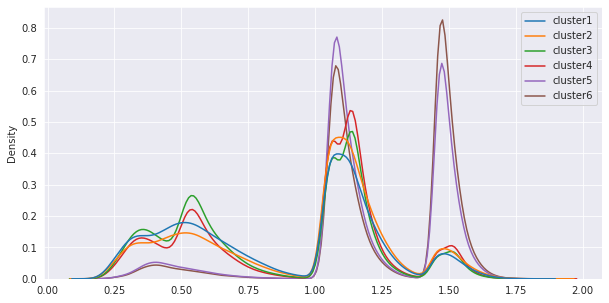

In [6]:
fig = plt.figure(figsize = (10,5))

if cd_feature:
    sns.kdeplot(data=train[cluster_cols])
else:
    ax = sns.countplot(data=train, x='cluster', hue="target")
    for p in ax.patches:
        ax.annotate(f'\n{p.get_height()}', (p.get_x()+0.2, p.get_height()), ha='center', va='top', color='white', size=5)

plt.show()

# PCA

In [7]:
pca = PCA()
X_pca = pca.fit_transform(train[useful_features])
T_pca = pca.transform(test[useful_features])

pca_cols = [f"PC{i+1}" for i in range(X_pca.shape[1])]

X_pca = pd.DataFrame(X_pca, columns=pca_cols, index=train.index)
T_pca = pd.DataFrame(T_pca, columns=pca_cols, index=test.index)

train = pd.concat([train, X_pca], axis=1)
test = pd.concat([test, T_pca], axis=1)
train.head()

,f0,f1,f2,f3,f4,f5,f6,f7,f8,f9,...,PC8,PC9,PC10,PC11,PC12,PC13,PC14,PC15,PC16,PC17
0,,,,,,,,,,,,,,,,,,,,,
0,0.205979,0.410993,0.176775,0.223581,0.423543,0.476140,0.413590,0.612021,0.534873,0.147295,...,0.074520,-0.075104,0.041586,-0.070753,-0.048137,0.051115,-0.020814,-0.012041,-0.053318,-0.023218
1,0.181004,0.473119,0.011734,0.213657,0.619678,0.441593,0.230407,0.686013,0.281971,0.238509,...,-0.195285,-0.122736,-0.066670,-0.005886,0.014093,0.026176,-0.049617,0.019438,-0.067284,-0.020651
2,0.182583,0.307431,0.325950,0.207116,0.605699,0.309695,0.493337,0.751107,0.536272,0.286813,...,0.082986,0.034063,-0.055371,-0.018122,-0.089091,0.000086,0.005424,-0.047551,-0.070289,-0.018998
3,0.180240,0.494592,0.008367,0.223580,0.760618,0.439211,0.432055,0.776147,0.483958,0.260886,...,0.030480,0.088542,-0.053029,-0.098216,-0.062032,0.146129,0.020623,-0.036973,-0.054462,-0.020765
4,0.177172,0.495513,0.014263,0.548819,0.625396,0.562493,0.117158,0.561255,0.077115,0.158321,...,-0.375175,0.064571,0.123073,-0.069018,-0.052590,0.031097,-0.045039,-0.061380,0.271678,-0.029590


In [8]:
loadings = pd.DataFrame(pca.components_, index=pca_cols, columns=train[useful_features].columns)
loadings.style.bar(align='mid', color=['#d65f5f', '#5fba7d'])

,f22,f179,f69,f58,f214,f78,f136,f156,f8,f3,f77,f200,f92,f185,f142,f115,f284
PC1,-0.999988,-0.001292,-0.000680,-0.000589,-0.000871,-0.001392,0.000536,0.003642,0.001001,0.000160,-0.000108,-0.000663,0.000258,-0.000186,-0.001151,-0.001006,0.001150
PC2,0.001135,0.000112,-0.000189,0.001237,0.000421,0.000410,-0.000701,-0.002768,-0.000666,0.000890,-0.000659,0.000329,0.001106,-0.000209,0.001694,0.000641,0.999991
PC3,-0.001237,0.000370,0.001661,-0.001071,0.007465,0.000113,-0.000741,-0.021853,0.004332,0.004103,-0.000503,-0.003679,-0.004384,0.001174,0.999690,0.002612,-0.001751
PC4,-0.003633,0.002026,0.001100,-0.001861,0.003853,0.000242,-0.002575,-0.999693,-0.001020,0.002461,-0.002141,0.002137,0.004722,-0.001996,-0.021891,0.006369,-0.002742
PC5,-0.000675,0.006843,0.000770,-0.004380,0.005800,-0.002315,-0.001019,0.002148,-0.007601,-0.001388,0.001631,0.999866,0.008874,0.001025,0.003750,0.000144,-0.000339
PC6,-0.000944,0.016516,0.000306,0.187509,0.981827,0.001816,-0.004041,0.003615,0.020910,-0.002481,-0.003118,-0.004845,0.004091,0.000778,-0.007140,-0.002108,-0.000615
PC7,-0.000409,0.004849,0.002423,0.980814,-0.188307,0.012904,-0.000145,-0.002681,0.046563,0.003880,0.006719,0.005796,-0.007635,0.001796,0.002170,-0.003570,-0.001109
PC8,0.000989,0.001173,-0.001157,-0.050259,-0.011338,0.017034,-0.000485,-0.001268,0.994867,-0.005080,-0.010392,0.008211,-0.083817,0.004957,-0.004623,-0.004118,0.000817
PC9,-0.000304,-0.030983,0.002417,-0.002157,0.006804,-0.006402,-0.001067,-0.004603,-0.084140,-0.010205,-0.017020,0.008381,-0.995607,0.001332,-0.004055,-0.011174,0.001048
PC10,-0.001267,0.999294,0.000267,-0.007842,-0.015168,-0.002771,-0.004427,0.001785,-0.004271,-0.003750,0.002399,-0.006569,-0.030778,0.001681,-0.000337,-0.007456,-0.000047


In [9]:
feature_cols += ["PC11", "PC12"]

# Add new features

In [10]:
def add_feature(df):
    df["new_f1"] = df["f255"]*df["f249"]
    df["new_f2"] = (df["cluster1"]+df["cluster3"])/(df["cluster2"]+df["cluster4"])
    return df

new_features = ["new_f1", "new_f2"]
train = add_feature(train)
test = add_feature(test)
feature_cols += new_features
train.head()

,f0,f1,f2,f3,f4,f5,f6,f7,f8,f9,...,PC10,PC11,PC12,PC13,PC14,PC15,PC16,PC17,new_f1,new_f2
0,,,,,,,,,,,,,,,,,,,,,
0,0.205979,0.410993,0.176775,0.223581,0.423543,0.476140,0.413590,0.612021,0.534873,0.147295,...,0.041586,-0.070753,-0.048137,0.051115,-0.020814,-0.012041,-0.053318,-0.023218,0,0.395722
1,0.181004,0.473119,0.011734,0.213657,0.619678,0.441593,0.230407,0.686013,0.281971,0.238509,...,-0.066670,-0.005886,0.014093,0.026176,-0.049617,0.019438,-0.067284,-0.020651,0,0.373190
2,0.182583,0.307431,0.325950,0.207116,0.605699,0.309695,0.493337,0.751107,0.536272,0.286813,...,-0.055371,-0.018122,-0.089091,0.000086,0.005424,-0.047551,-0.070289,-0.018998,0,2.198068
3,0.180240,0.494592,0.008367,0.223580,0.760618,0.439211,0.432055,0.776147,0.483958,0.260886,...,-0.053029,-0.098216,-0.062032,0.146129,0.020623,-0.036973,-0.054462,-0.020765,1,0.389759
4,0.177172,0.495513,0.014263,0.548819,0.625396,0.562493,0.117158,0.561255,0.077115,0.158321,...,0.123073,-0.069018,-0.052590,0.031097,-0.045039,-0.061380,0.271678,-0.029590,1,1.869352


# Mutual Information

In [11]:
%%time
x = train.iloc[:5000,:][feature_cols].copy()
y = train.iloc[:5000,:]['target'].copy()
mi_scores = mutual_info_regression(x, y)
mi_scores = pd.Series(mi_scores, name="MI Scores", index=x.columns)
mi_scores = mi_scores.sort_values(ascending=False)

CPU times: user 35.4 s, sys: 18.4 s, total: 53.9 s
Wall time: 54 s


In [12]:
top = 20
fig = px.bar(mi_scores, x=mi_scores.values[:top], y=mi_scores.index[:top])
fig.update_layout(
    title=f"Top {top} Strong Relationships Between Feature Columns and Target Column",
    xaxis_title="Relationship with Target",
    yaxis_title="Feature Columns",
    yaxis={'categoryorder':'total ascending'},
    colorway=["blue"]
)
fig.show()

# KFold

In [13]:
folds = 5
train["kfold"] = -1
kf = StratifiedKFold(n_splits=folds, shuffle=True, random_state=42)

for fold, (train_indicies, valid_indicies) in enumerate(kf.split(train,train["target"])):
    train.loc[valid_indicies, "kfold"] = fold

# XGBoost

In [14]:
%%time
final_test_predictions = []
scores = []

for fold in range(folds):
    x_train = train[train.kfold != fold].copy()
    x_valid = train[train.kfold == fold].copy()
    x_test  = test[feature_cols].copy()
    
    y_train = x_train['target']
    y_valid = x_valid['target']
    
    x_train = x_train[feature_cols]
    x_valid = x_valid[feature_cols]

    xgb_params = {
        'eval_metric': 'auc', 
        'objective': 'binary:logistic', 
        'tree_method': 'gpu_hist', 
        'gpu_id': 0, 
        'predictor': 'gpu_predictor', 
        'n_estimators': 10000, 
        'learning_rate': 0.01063045229441343, 
        'gamma': 0.24652519525750877, 
        'max_depth': 4, 
        'seed': 42,       
        'min_child_weight': 366, 
        'subsample': 0.6423040816299684, 
        'colsample_bytree': 0.7751264493218339, 
        'colsample_bylevel': 0.8675692743597421, 
        'use_label_encoder': False,
        'lambda': 0, 
        'alpha': 10
    }
    
    xgb_model = XGBClassifier(**xgb_params)
    xgb_model.fit(x_train, y_train, eval_set=[(x_valid, y_valid)], verbose=False)
    
    preds_train = xgb_model.predict_proba(x_train)[:,1]
    preds_valid = xgb_model.predict_proba(x_valid)[:,1]
    auc_train = roc_auc_score(y_train, preds_train)
    auc = roc_auc_score(y_valid, preds_valid)
    print("Fold",fold,", train:", f"{auc_train:.6f}", ", valid:", f"{auc:.6f}")
    scores.append(auc)
    
    preds_test = xgb_model.predict_proba(x_test)[:,1]
    final_test_predictions.append(preds_test)
    
    
print("AVG AUC:",np.mean(scores))

Fold 0 , train: 0.869710 , valid: 0.858670
Fold 1 , train: 0.870299 , valid: 0.855787
Fold 2 , train: 0.869929 , valid: 0.857580
Fold 3 , train: 0.870395 , valid: 0.856059
Fold 4 , train: 0.870146 , valid: 0.856693
AVG AUC: 0.8569576884614891
CPU times: user 41min 28s, sys: 28.6 s, total: 41min 56s
Wall time: 41min 32s


# SHAP Values

/opt/conda/lib/python3.7/site-packages/xgboost/core.py:104: UserWarning:

ntree_limit is deprecated, use `iteration_range` or model slicing instead.



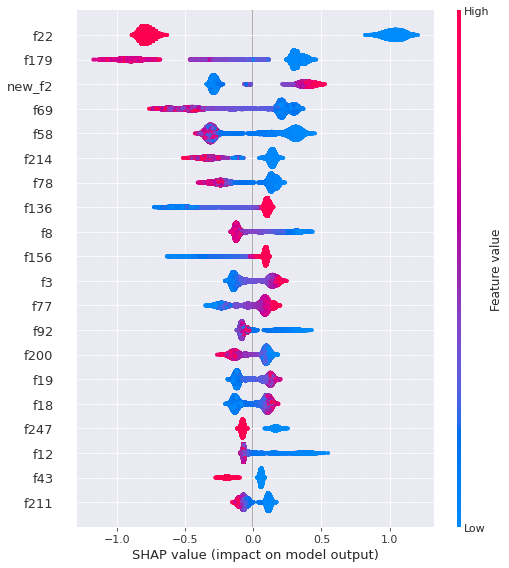

In [15]:
shap_values = shap.TreeExplainer(xgb_model).shap_values(x_valid)
shap.summary_plot(shap_values, x_valid)

In [16]:
idx = 5
data_for_prediction = x_valid.iloc[idx]
data_for_prediction_array = data_for_prediction.values.reshape(1, -1)


print(xgb_model.predict_proba(data_for_prediction_array))

shap.initjs()
explainer = shap.TreeExplainer(xgb_model)
shap_values = explainer.shap_values(data_for_prediction_array)
shap.force_plot(explainer.expected_value, shap_values, data_for_prediction)

[[0.87477833 0.12522165]]


# Plot Prediction

In [17]:
labels = [f'fold {i}' for i in range(folds)]

fig = ff.create_distplot(final_test_predictions, labels, bin_size=.3, show_hist=False, show_rug=False)
fig.show()

In [18]:
sample_submission['target'] = np.mean(np.column_stack(final_test_predictions), axis=1)
sample_submission.to_csv("submission.csv", index=False)